<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#TF-IDF-и-логистическая-регрессия" data-toc-modified-id="TF-IDF-и-логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>TF-IDF и логистическая регрессия</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Анализ тональности текста

Нужно построить модель машинного обучения для определения токсичных комментариев.

Метрика качества *F1* должна быть >= 0.75. 

Были использованы следующие модели:
- CatBoost
- TF-IDF + Logistic Regression

**Описание данных**   
Набор текстов с разметкой о токсичности.

## Подготовка

In [1]:
#импортирование нужных библиотек:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords') 

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from catboost import Pool, CatBoostClassifier
import spacy

from tqdm.notebook import trange, tqdm


#игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

import re

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('datasets/toxic_comments.csv')

Изучим данные:

In [3]:
print(data.head())
print('--------------')
print(data.shape)
print('--------------')
print(data.info())

                                                text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0
--------------
(159571, 2)
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Посмотрим, есть ли дисбаланс классов:

0    0.898321
1    0.101679
Name: toxic, dtype: float64

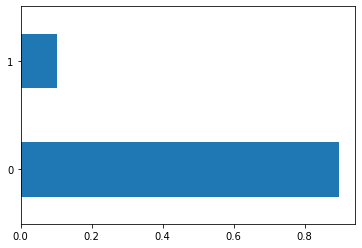

In [4]:
disbalance = data['toxic'].value_counts(normalize=True)
disbalance.plot(kind='barh')
disbalance

Имеется значительный дисбаланс.

Проведем лемматизацию текстов:

In [5]:
corpus = data['text'].values
display(corpus.shape)

(159571,)

In [6]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def lemmatize(text):
    doc = nlp(text)

    lemm_text = " ".join([token.lemma_ for token in doc])
        
    return lemm_text


def clear_text(text):
    # удалим все кроме букв:
    temp = re.sub(r"[^a-zA-Z ]", ' ', text)
    
    # удалим единичные символы:
    temp = re.sub(r'\s+[a-zA-Z]\s+', ' ', temp)
    temp = re.sub(r'\^[a-zA-Z]\s+', ' ', temp) 
    
    # множественные пробелы заменим на одинарный:
    temp = re.sub(r'\s+', ' ', temp, flags=re.I)
        
    # приведем к нижнему регистру:
    temp = temp.lower()
    
    return " ".join(temp.split())

In [7]:
%%time
for i in tqdm(range(0,corpus.shape[0]), desc='corpus size'):
    data.loc[i, 'lemm_text'] = lemmatize(clear_text(corpus[i]))


CPU times: user 1h 4min 7s, sys: 28.6 s, total: 1h 4min 36s
Wall time: 1h 6min 56s


In [8]:
del corpus

Удалим пропуски:

In [5]:
# в связи с частой смертью ядра, лемматизированные тексты были сохранены в .csv файл
#data.to_csv('texts_lemm.csv')
data = pd.read_csv('texts_lemm.csv', index_col=0)


In [6]:
data.isna().sum()

text         0
toxic        0
lemm_text    7
dtype: int64

In [7]:
data.dropna(inplace=True)

In [8]:
corpus = data.drop(['text', 'toxic'], axis=1)
labels = data['toxic']
display(corpus.head())

,lemm_text
0,explanation why the edit make under -PRON- use...
1,d aww -PRON- match this background colour m se...
2,hey man m really not try to edit war -PRON- ju...
3,more can make any real suggestion on improveme...
4,-PRON- sir be -PRON- hero any chance -PRON- re...


In [9]:
del data

## Обучение

In [14]:
results = pd.DataFrame([], columns = ['model', 'f1', 'best_parameters'])

### CatBoost

In [16]:
features_all, features_test, target_all, target_test = train_test_split(corpus, labels.values, test_size=0.2, random_state=12345, stratify=labels)
features_train, features_valid, target_train, target_valid = train_test_split(features_all, target_all, test_size=0.25, random_state=12345, stratify=target_all)

print(features_all.shape)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(corpus.shape)

(127656, 1)
(95742, 1)
(31914, 1)
(31915, 1)
(159571, 1)


In [17]:
text_features = ['lemm_text']

In [18]:
train_pool = Pool(
    features_train, 
    target_train, 
    text_features=text_features, 
    feature_names=list(features_train)
)
valid_pool = Pool(
    features_valid, 
    target_valid,
    text_features=text_features, 
    feature_names=list(features_train)
)

catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'use_best_model': True,
    'verbose': 100,
}

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.6930628	test: 0.7292138	best: 0.7292138 (0)	total: 923ms	remaining: 15m 22s
100:	learn: 0.7534018	test: 0.7647259	best: 0.7648561 (99)	total: 1m 36s	remaining: 14m 14s
200:	learn: 0.7714466	test: 0.7689690	best: 0.7695704 (187)	total: 3m 8s	remaining: 12m 29s
300:	learn: 0.7858450	test: 0.7704360	best: 0.7718761 (277)	total: 4m 41s	remaining: 10m 52s
400:	learn: 0.7962826	test: 0.7696237	best: 0.7719239 (364)	total: 6m 13s	remaining: 9m 18s
500:	learn: 0.8046657	test: 0.7705392	best: 0.7719239 (364)	total: 7m 45s	remaining: 7m 43s
600:	learn: 0.8122941	test: 0.7700136	best: 0.7719239 (364)	total: 9m 18s	remaining: 6m 10s
700:	learn: 0.8177390	test: 0.7692829	best: 0.7719239 (364)	total: 10m 49s	remaining: 4m 37s
800:	learn: 0.8245475	test: 0.7697513	best: 0.7719239 (364)	total: 12m 22s	remaining: 3m 4s
900:	learn: 0.8297968	test: 0.7703503	best: 0.7719239 (364)	total: 13m 55s	remaining: 1m 31s
999:	learn: 0.8345827	test: 0.7699340	best: 0.7719239 (364)	total: 15m 26s	remain

In [19]:
results = results.append({'model': model, 'f1' : model.get_best_score()['validation']['F1'], 'best_parameters' : catboost_params}, ignore_index=True)

In [20]:
pred = model.predict(features_test)
print(f1_score(target_test,pred))

0.785629150349055


Значения f1 как на валидационной, так и на тестовой выборках удовлетворяет нашим требованиям (>=0.75). Обучим CatBoost со сбаланисированными весами, так как у нас дисбаланс классов:

In [21]:
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'use_best_model': True,
    'verbose': 100,
    'auto_class_weights':'Balanced'
}

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.8438473	test: 0.8674256	best: 0.8674256 (0)	total: 903ms	remaining: 15m 1s
100:	learn: 0.8902611	test: 0.8993431	best: 0.8999298 (99)	total: 1m 38s	remaining: 14m 36s
200:	learn: 0.9046933	test: 0.9034335	best: 0.9045284 (191)	total: 3m 15s	remaining: 12m 58s
300:	learn: 0.9140141	test: 0.9036314	best: 0.9045284 (191)	total: 4m 52s	remaining: 11m 18s
400:	learn: 0.9208660	test: 0.9042073	best: 0.9045284 (191)	total: 6m 26s	remaining: 9m 37s
500:	learn: 0.9278149	test: 0.9047674	best: 0.9048767 (416)	total: 8m 2s	remaining: 8m
600:	learn: 0.9331053	test: 0.9052895	best: 0.9052895 (600)	total: 9m 37s	remaining: 6m 23s
700:	learn: 0.9375483	test: 0.9047147	best: 0.9054344 (657)	total: 11m 12s	remaining: 4m 46s
800:	learn: 0.9423782	test: 0.9043549	best: 0.9054344 (657)	total: 12m 47s	remaining: 3m 10s
900:	learn: 0.9468776	test: 0.9037875	best: 0.9054344 (657)	total: 14m 23s	remaining: 1m 34s
999:	learn: 0.9507156	test: 0.9033554	best: 0.9054344 (657)	total: 15m 58s	remaining:

In [22]:
results = results.append({'model': model, 'f1' : model.get_best_score()['validation']['F1'], 'best_parameters' : catboost_params}, ignore_index=True)
results

,model,f1,best_parameters
0,<catboost.core.CatBoostClassifier object at 0x...,0.771924,"{'iterations': 1000, 'learning_rate': 0.1, 'ev..."
1,<catboost.core.CatBoostClassifier object at 0x...,0.905434,"{'iterations': 1000, 'learning_rate': 0.1, 'ev..."


In [23]:
pred = model.predict(features_test)

In [24]:
print(f1_score(target_test,pred))

0.7306517311608961


f1 для взвешенной модели на валидационной выборке очень быстро сошлась к высокому значению, видимо модель быстро переобучилась. На тестовой выборке результат не такой хороший.

In [25]:
del features_train, features_valid, features_test, target_train, target_valid, target_test, pred

### TF-IDF и логистическая регрессия

Ядро постоянно умирает, тетрадка запускается только в 2 захода: сначала CatBoost, потом Лог регрессия.

In [11]:
features_train, features_test, target_train, target_test = train_test_split(corpus, labels.values, test_size=0.25, random_state=12345, stratify=labels)

In [12]:
print(features_train.shape)
print(features_test.shape)
print(corpus.shape)

print(Counter(target_train))
print(Counter(target_test))
print(Counter(labels))


(119673, 1)
(39891, 1)
(159564, 1)
Counter({0: 107504, 1: 12169})
Counter({0: 35835, 1: 4056})
Counter({0: 143339, 1: 16225})


In [11]:
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words, max_features=1500, min_df=5, max_df=0.7) 
tf_idf_train = count_tf_idf.fit_transform(features_train.lemm_text).toarray()

print("Размер матрицы:", tf_idf_train.shape)
del features_train

Размер матрицы: (119673, 1500)


In [12]:
%%time
params_logicRegression = {'solver': ['lbfgs', 'liblinear'],
                      'C': np.logspace(-1,1, num=6)
                      }
grid = GridSearchCV(
        estimator=LogisticRegression(random_state=12345, penalty='l2', class_weight='balanced'),
        param_grid=params_logicRegression,
        scoring='f1',
        cv=3)

grid.fit(tf_idf_train, target_train)

display(grid.best_score_)


0.6441297664650231

CPU times: user 12min 9s, sys: 2min 3s, total: 14min 12s
Wall time: 14min 13s


In [15]:
results = results.append({'model' : grid, 'f1':grid.best_score_, 'best_parameters':grid.best_params_}, ignore_index=True)
results 

,model,f1,best_parameters
0,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.64413,"{'C': 0.251188643150958, 'solver': 'lbfgs'}"


In [16]:
tf_idf_test = count_tf_idf.transform(features_test.lemm_text).toarray()

In [17]:
pred = grid.predict(tf_idf_test)
print(f1_score(target_test,pred))

0.6398176291793314


Логистическая регрессия, обученная на TF-IDF, показывает низкие значения f1 на кросс-валидации и на тестовой выборке.

Облегченный вариант регрессии:

In [13]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, min_df=0.0001) 
tf_idf_tr = count_tf_idf.fit_transform(features_train.lemm_text) 

tf_idf_te = count_tf_idf.transform(features_test.lemm_text) 
features_train = tf_idf_tr 
features_test = tf_idf_te

model = LogisticRegression(class_weight='balanced', C=10.0, penalty='l2') 
model.fit(features_train, target_train) 
predictions = model.predict(features_test) 
f1_tfidf_te = f1_score(target_test, predictions) 
print('f1 на тестовой выборке:', f1_tfidf_te)

f1 на тестовой выборке: 0.7389549702633815


## Выводы

Текстовые данные для оценки тональности были подготовлены и лемматизированы. Для обучения были выбраны модели CatBoostClassifier и Логистическая регрессия. Для обучения Логистической регрессии тексты были переведены в числовые представления с помощью TF-IDF. 

Наилучшее значение метрики f1 (>=0.75) показала модель CatBoostClassifier без параметра сбалансированных классов.